# Kaggle - Spaceship Titanic
With Neural Network from keras

In [97]:
#import libraries
from http.client import ImproperConnectionState
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn 
from sklearn.model_selection import train_test_split
import time
import graphviz
import os
import pickle
from keras import models, layers, optimizers, regularizers
import matplotlib.pyplot as plt

In [98]:
#load data
version_data = "v1_4"
path_data = f'../data/preprocessed/{version_data}/' 
(x_test, x_train, y_test, y_train, x_predict) = [np.load(f'{path_data}{f}.npy', allow_pickle=True) 
                                                for f in ('X_test', 'X_train', 'y_test', 'y_train',  'X_predict')]
                                                
#split data
y_train=np.asarray(y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)  

y_train = y_train.reshape((y_train.shape[0],1)) *1
y_val = y_val.reshape((y_val.shape[0],1)) *1
y_test = y_test.reshape((y_test.shape[0],1)) *1

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1])) *1
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1])) *1


y_train = tf.convert_to_tensor(y_train,dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val,dtype=tf.float32)
x_train = tf.convert_to_tensor(x_train,dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val,dtype=tf.float32)

print(f'x_train.shape: {x_train.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'x_test.shape: {x_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'y_test.shape: {y_test.shape}')

x_train.shape: (5563, 18)
x_val.shape: (1391, 18)
x_test.shape: (1739, 18)
y_train.shape: (5563, 1)
y_val.shape: (1391, 1)
y_test.shape: (1739, 1)


### KERAS
--> Deep Neural Network

Train model

In [109]:
#define model
tf.keras.backend.clear_session()
model = keras.Sequential([
                            keras.layers.Dense(128, activation='relu', input_shape=[len(x_train[1])]),
                            keras.layers.Dense(64, activation='relu'),
                            keras.layers.Dropout(0.1),
                            keras.layers.Dense(64, activation='relu'),
                            keras.layers.Dropout(0.1),
                            keras.layers.Dense(32, activation='relu'),
                            keras.layers.Dense(1, activation='sigmoid')
                                ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.99, beta_2=0.995, epsilon=1e-08, amsgrad=False),
                loss='binary_crossentropy',
                metrics=['binary_accuracy'],
                )

# Model weights are saved at the end of every epoch,
    # if it's the best seen so far.
checkpoint_filepath = '../models/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='binary_accuracy',
    mode='max',
    save_best_only=True)            

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2432      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 3

In [110]:
start_time = time.time()  #track the model development time
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500, callbacks=[model_checkpoint_callback], batch_size=2048)
end_time = time.time()
duration = end_time - start_time
print("Training duration: %s sec" % (duration)) 
model.load_weights(checkpoint_filepath)

#test performance
y_prob = model.predict(x_test)
y_pred = np.where(y_prob > 0.5, 1, 0)
categorical_accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Categorical accuracy (test): %s" % categorical_accuracy)

Epoch 1/500
3/3 [==============================] - 0s 77ms/step - loss: 0.6937 - binary_accuracy: 0.5150 - val_loss: 0.6905 - val_binary_accuracy: 0.5363
Epoch 2/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6911 - binary_accuracy: 0.5294 - val_loss: 0.6878 - val_binary_accuracy: 0.5457
Epoch 3/500
3/3 [==============================] - 0s 24ms/step - loss: 0.6884 - binary_accuracy: 0.5511 - val_loss: 0.6851 - val_binary_accuracy: 0.5694
Epoch 4/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6861 - binary_accuracy: 0.5725 - val_loss: 0.6824 - val_binary_accuracy: 0.5881
Epoch 5/500
3/3 [==============================] - 0s 25ms/step - loss: 0.6822 - binary_accuracy: 0.5928 - val_loss: 0.6798 - val_binary_accuracy: 0.6111
Epoch 6/500
3/3 [==============================] - 0s 29ms/step - loss: 0.6802 - binary_accuracy: 0.6065 - val_loss: 0.6771 - val_binary_accuracy: 0.6326
Epoch 7/500
3/3 [==============================] - 0s 22ms/step - loss: 0.67

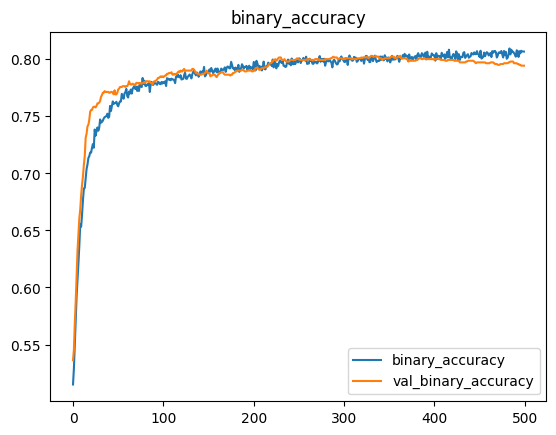

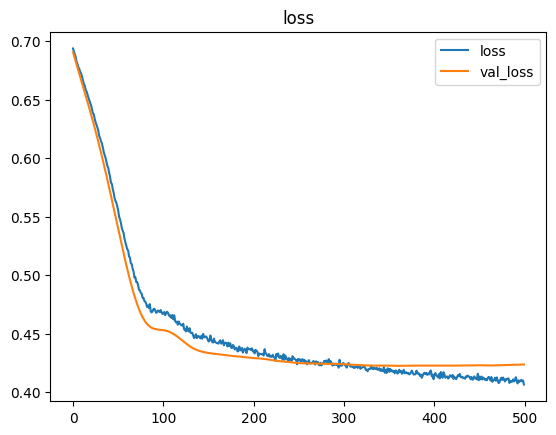

In [112]:
for metric in 'binary_accuracy', 'loss':
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.legend()
    plt.title(f"{metric}")
    plt.show()

tf.keras.backend.clear_session()

SAVE MODEL

In [113]:
model_id = 'NN__'+ version_data + '__05'
print(f"Saving model {model_id} ...")

#save model
if not os.path.exists(f'../models/{model_id}'):
        os.mkdir(f'../models/{model_id}')
pickle.dump(model, open(f'../models/{model_id}/model.pkl', 'wb'))

#save results
timestamp = time.strftime("%Y_%m_%d at %H_%M")
print(timestamp)
print(f'categorical_accuracy: {categorical_accuracy}')

overview = pd.read_csv('../models/prediction_overview.csv')
new_row = {'model_id': model_id, 'timestamp': timestamp, 'categorical_accuracy': categorical_accuracy}
overview = pd.concat([overview, pd.DataFrame(new_row, index=[0])])
overview = overview[{'model_id', 'timestamp', 'categorical_accuracy'}]
overview.drop_duplicates(inplace=True)
print(overview)
overview.to_csv('../models/prediction_overview.csv')

Saving model NN__v1_4__05 ...
INFO:tensorflow:Assets written to: ram://7df1ceb3-05ae-41f4-aec2-8ef45f86a257/assets
2022_09_22 at 05_34
categorical_accuracy: 0.78205865439908
              timestamp           model_id  categorical_accuracy
0   2022_09_21 at 22_46  xgboost__v1_0__01              0.794710
1   2022_09_21 at 22_48       NN__v1_2__01              0.774583
2   2022_09_21 at 23_02       NN__v1_2__02              0.779758
3   2022_09_21 at 23_38       NN__v1_2__03              0.793560
4   2022_09_22 at 04_09  xgboost__v1_3__01              0.782059
5   2022_09_22 at 04_12  xgboost__v1_3__01              0.780334
6   2022_09_22 at 04_19  xgboost__v1_3__01              0.787234
7   2022_09_22 at 04_58  xgboost__v1_4__01              0.741231
8   2022_09_22 at 05_00       NN__v1_4__05              0.729155
9   2022_09_22 at 05_02  xgboost__v1_4__01              0.787809
10  2022_09_22 at 05_03       NN__v1_4__05              0.781484
11  2022_09_22 at 05_11       NN__v1_4__05    

/tmp/ipykernel_481864/4191078948.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  overview = overview[{'model_id', 'timestamp', 'categorical_accuracy'}]


In [103]:
############# use to create new version and DELETE OLD VERSIONS #############

#overview = pd.DataFrame(columns=['model_id', 'timestamp', 'categorical_accuracy', 'binary_accuracy'])
#overview.to_csv('../models/prediction_overview.csv')